### Get OSI SAF SIC at Hausgarten stations

##### Purpose:
    - Plot maps with SIC anomalies like in Soltwedel 2016 paper
    - Plot map with Hausgarten stations

#### Modules and functions

In [1]:
import numpy as np
import pylab as plt
import xarray as xr
import os,sys
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pyproj
import pandas as pd
import datetime
import glob
import calendar
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.lines as mlines

In [2]:
def convert_to_decimal_degrees(coord_str):
    # Remove the degree symbol and split the string
    degree_str, minute_str_with_direction = coord_str.split('°')
    minute_str, direction = minute_str_with_direction.split("'")

    # Remove any commas from the minute string and convert to float
    minutes = float(minute_str.replace(',', '.'))

    # Convert degree string to float
    degrees = float(degree_str)

    # Calculate decimal degrees
    decimal_degrees = degrees + minutes / 60

    # If the direction is 'S' or 'W', make the decimal degrees negative
    if direction.strip() in ['S', 'W']:
        decimal_degrees = -decimal_degrees

    return decimal_degrees

In [3]:
def xydist(x,y,x_2d,y_2d):
    return np.sqrt((x-x_2d)**2 + (y-y_2d)**2)

In [4]:
def XY_To_LatLon(x,y,projstring):
    p1=pyproj.Proj(projstring,preserve_units=True)
    (lat,lon)=p1(x,y,inverse=True,)
    return(lat,lon)

In [5]:
def LatLon_To_XY(lat,lon,projstring):
    p1=pyproj.Proj(projstring,preserve_units=True)
    (x,y)=p1(lat,lon,inverse=False,)
    return(x,y)

In [6]:
def get_coorddicts(df):
    londict = {stationname:np.round(lon,3) for stationname,lon in zip(df["Station ID"],df["lon_decimal"])}
    latdict = {stationname:np.round(lat,3) for stationname,lat in zip(df["Station ID"],df["lat_decimal"])}
    return londict,latdict

In [7]:
def design_map(ax,title,hemisphere,showlabels = False):
    if hemisphere == "nh":
        ax.set_extent([-30, 30, 75,85], ccrs.PlateCarree())
    elif hemisphere == "sh":
        ax.set_extent([-180, 180, -60,-90], ccrs.PlateCarree())
    else:
        sys.exit("Hemisphere needs to be either 'nh' or 'sh'!")
    ax.set_title(title,fontsize = 14,fontweight = "bold") # set title
    ax.coastlines()
    ax.gridlines()
    #ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='#F5E5A0')  # Adjust facecolor as needed
    ax.set_facecolor('#F5E5A0')
    if showlabels:
        ax.gridlines().label_style = {'fontsize': 14}
        gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, alpha=0.5, linestyle='--', draw_labels=True)
        gl.xlabel_style = {'size': 14, 'color': 'black'}
        gl.ylabel_style = {'size': 14, 'color': 'black'}
        gl.top_labels = None       # Disable labels at the top
        gl.bottom_labels = True     # Enable labels at the bottom
        gl.left_labels = True       # Enable labels on the left
        gl.right_labels = None      # Disable labels on the right

In [8]:
def get_dirs(date):
    if os.path.exists("/Users/vludwig/"):
        basedir = "/Users/vludwig/06_HAUSGARTEN/02_DATA"
        plotdir = "/Users/vludwig/06_HAUSGARTEN/03_PLOTS/"
        #plotdir_paper = "/Users/vludwig/02_LITERATURE/01_PAPERS/04_OWN/04_HAUSGARTEN/02_TEX/01_V1/01_INPUT/01_FIGURES/"
        plotdir_paper = f"/Users/vludwig/02_LITERATURE/01_PAPERS/04_OWN/04_HAUSGARTEN/02_TEX/02_COLLABTEX/01_VERSIONS/{date}/02_FIGURES"
        datadir_csv = os.path.join(basedir,"01_CSV")
        #datadir_nc = os.path.join(basedir,"02_NETCDF/01_MONTHLY")
        datadir_nc = os.path.join(basedir,"02_NETCDF/02_MONTHLY_OWN")
    else:
        basedir = "/albedo/work/user/vludwig/06_HAUSGARTEN/02_DATA"
        plotdir = "/albedo/home/vludwig/06_HAUSGARTEN/03_PLOTS/"
        datadir_csv = os.path.join(basedir,"01_CSV")
        datadir_nc = "/albedo/work/user/vludwig/05_SINXS/02_DATA/00_MISC/osisaf/monthly/"
    return basedir,plotdir,plotdir_paper,datadir_csv,datadir_nc

In [9]:
def col2cluster(cluster):
    if cluster=="EG":
        col = "salmon"
    elif cluster=="N":
        col = "royalblue"
    else:
        print(f"Cluster {cluster} unknown")
    return col

#### Load data

In [11]:
today = datetime.datetime.strftime(datetime.datetime.now(),"%Y%m%d")

In [33]:
basedir,plotdir_tmp,plotdir_paper,datadir_csv,datadir_nc = get_dirs(today)
plotdir = os.path.join(plotdir_tmp,"02_MAPS")

#### Get coordinates

##### OSI SAF coordinates

In [14]:
coordfile = xr.open_dataset(os.path.join(datadir_nc,"ice_conc_nh_ease2-250_cdr-v3p0_199901.nc"))
#coordfile = xr.open_dataset(os.path.join(datadir_hausgarten,"ice_conc_nh_ease2-250_icdr-v3p0_202408111200.nc"))
x_2d,y_2d = np.meshgrid(coordfile.coords["xc"],coordfile.coords["yc"])

In [15]:
lon_2d,lat_2d = XY_To_LatLon(x_2d,y_2d,projstring = "+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs")

In [16]:
projstring = "+proj=laea +lat_0=90 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs"

##### Hausgarten coordinates

In [17]:
df_hausgarten = pd.read_excel(os.path.join(datadir_csv,"average HG-Stations.xlsx"))

In [18]:
# Define the list of Station IDs you want to filter by
station_ids = ['EG-I', 'EG-II', 'EG-III', 'EG-IV', 'N3', 'N4', 'N5']
station_ids_noice = ['SV-I', 'SV-II', 'SV-III', 'SV-IV', ' I', ' II', ' III', ' IV',' V',' VI',' VII',' VIII',' IX','S3']

# Select rows where "Station ID" is in the specified list
hausgarten_ice = df_hausgarten[df_hausgarten['Station ID'].isin(station_ids)]
hausgarten_noice = df_hausgarten[df_hausgarten['Station ID'].isin(station_ids_noice)]
inds = hausgarten_ice.index.to_list()

In [19]:
hausgarten_ice.to_csv(os.path.join(datadir_csv,"hausgarten_ice.csv"))
hausgarten_noice.to_csv(os.path.join(datadir_csv,"hausgarten_noice.csv"))

In [20]:
hausgarten_ice["lat_decimal"] = [convert_to_decimal_degrees(coordstr) for coordstr in hausgarten_ice["average lat"]]
hausgarten_ice["lon_decimal"] = [convert_to_decimal_degrees(coordstr) for coordstr in hausgarten_ice["average long"]]
hausgarten_ice["color"] = plt.rcParams['axes.prop_cycle'].by_key()['color'][0:hausgarten_ice.shape[0]]

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_16675/1430737232.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hausgarten_ice["lat_decimal"] = [convert_to_decimal_degrees(coordstr) for coordstr in hausgarten_ice["average lat"]]
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_16675/1430737232.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hausgarten_ice["lon_decimal"] = [convert_to_decimal_degrees(coordstr) for coordstr in hausgarten_ice["average long"]]
/var/folders/d6/cf68q

In [21]:
hausgarten_noice["lat_decimal"] = [convert_to_decimal_degrees(coordstr) for coordstr in hausgarten_noice["average lat"]]
hausgarten_noice["lon_decimal"] = [convert_to_decimal_degrees(coordstr) for coordstr in hausgarten_noice["average long"]]
hausgarten_noice["color"] = "pink"

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_16675/3617108085.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hausgarten_noice["lat_decimal"] = [convert_to_decimal_degrees(coordstr) for coordstr in hausgarten_noice["average lat"]]
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_16675/3617108085.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hausgarten_noice["lon_decimal"] = [convert_to_decimal_degrees(coordstr) for coordstr in hausgarten_noice["average long"]]
/var/folders/

In [22]:
londict,latdict = get_coorddicts(hausgarten_ice)
londict_noice,latdict_noice = get_coorddicts(hausgarten_noice)

### OSI SAF data

In [23]:
fns_osisaf = list(np.sort(glob.glob(f"{datadir_nc}/ice_conc_nh_ease2-250_*")))

In [24]:
fns_osisaf[-1]

'/Users/vludwig/06_HAUSGARTEN/02_DATA/02_NETCDF/02_MONTHLY_OWN/ice_conc_nh_ease2-250_icdr-v3p0_202410.nc'

In [25]:
ds_all = xr.open_mfdataset(fns_osisaf)

In [26]:
refperiod = (1981,2000) # period to calculate anomalies against
oldperiod = (1999,2014) # period from 2016 Soltwedel paper
newperiod = (2015,2024) # period to show once per year in maps

In [27]:
month = 7

In [28]:
ds_month = ds_all.sel(time=ds_all['time'].dt.month == month)

In [29]:
ds_ref = ds_month.sel(time=np.logical_and(ds_month['time'].dt.year >=refperiod[0],ds_month['time'].dt.year<=refperiod[1]))
ds_new = ds_month.sel(time=np.logical_and(ds_month['time'].dt.year >=newperiod[0],ds_month['time'].dt.year<=newperiod[1]))
ds_old = ds_month.sel(time=np.logical_and(ds_month['time'].dt.year >=oldperiod[0],ds_month['time'].dt.year<=oldperiod[1]))

In [30]:
sic_anom_new = ds_new.sea_ice_concentration-ds_ref.sea_ice_concentration.mean(dim = "time")
sic_anom_old = ds_old.sea_ice_concentration-ds_ref.sea_ice_concentration.mean(dim = "time")

#### Plot map

##### Mean SIC

In [31]:
station_ids

['EG-I', 'EG-II', 'EG-III', 'EG-IV', 'N3', 'N4', 'N5']

In [29]:
station_ids

['EG-I', 'EG-II', 'EG-III', 'EG-IV', 'N3', 'N4', 'N5']

In [32]:
def add_contour(ax,arr,col = "red"):
    contour = ax.contour(
    x_2d*1e3, y_2d*1e3, arr, 
    levels=[15],  # The value at which the contour is drawn (15%)
    colors=[col],  # Contour line color
    linewidths=2,  # Contour line width
    linestyles='dashed'
    )
    # Create a custom legend entry for the contour line
    contour_legend = mlines.Line2D([], [], color='red', linestyle='dashed', linewidth=2, label='15% Contour')
    
    # Add the legend to the axis
   # ax.legend(handles=[contour_legend], loc='upper right', fontsize=12)

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_32078/4208479249.py:43: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_32078/4208479249.py:46: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


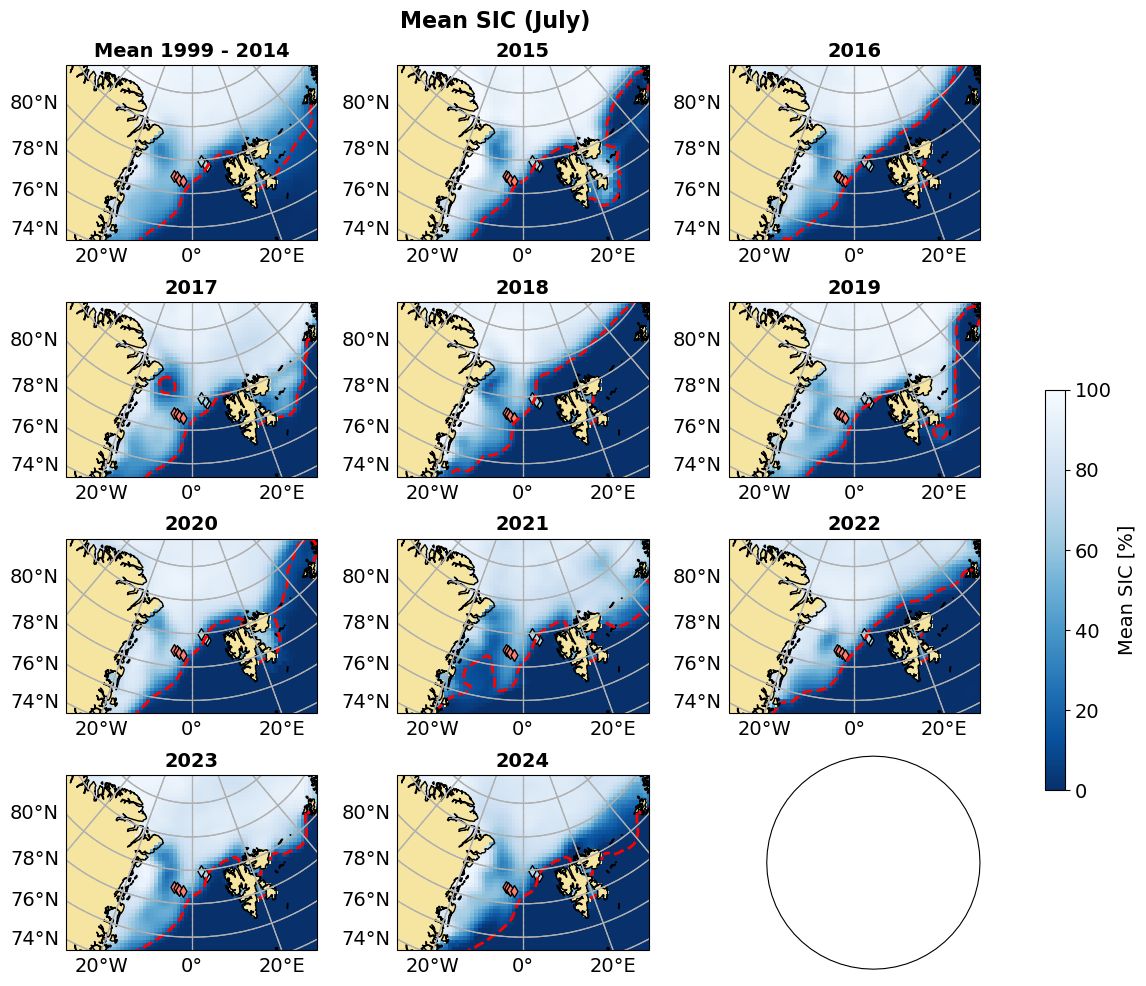

In [33]:
### NEW PLOT ###

fig, axs = plt.subplots(nrows=4,ncols=3,subplot_kw={'projection': ccrs.LambertAzimuthalEqualArea(central_longitude=0, central_latitude=90)},figsize=(10,10))
fig.subplots_adjust(wspace=0.2, hspace=0.2)
fig.suptitle(f"Mean SIC ({calendar.month_name[month]})",fontsize = 16, y = .98,fontweight = "bold")
for i,ax in enumerate(axs.flat[:10]):
    #print(ax)
    
    if i>=sic_anom_new.shape[0]:
        continue
    if i == 0:
        design_map(ax,title = f"Mean {oldperiod[0]} - {oldperiod[1]}", hemisphere="nh",showlabels = True)
        im = ax.pcolormesh(x_2d*1e3,y_2d*1e3,ds_old.sea_ice_concentration.mean(dim = "time"),cmap = plt.cm.Blues_r)
        add_contour(ax,ds_old.sea_ice_concentration.mean(dim = "time"))
        #continue
    else:
        design_map(ax,title = f"{ds_new.time.dt.year[i-1].values}", hemisphere="nh",showlabels = True)
        im = ax.pcolormesh(x_2d*1e3,y_2d*1e3,ds_new.sea_ice_concentration.isel(time=i-1),cmap = plt.cm.Blues_r,vmin = 0,vmax = 100)
        add_contour(ax,ds_new.sea_ice_concentration.isel(time=i-1))
    for station_id in station_ids:
        if station_id.startswith("EG"):
            station_color = "salmon"
        else:
            station_color = "lightblue"
        ax.scatter(londict[station_id],latdict[station_id], transform = ccrs.PlateCarree(),marker = "d",facecolor = station_color, edgecolor = "black")


ax = axs.flat[10]
design_map(ax,title = f"{ds_new.time.dt.year[-1].values}", hemisphere="nh",showlabels = True)
im = ax.pcolormesh(x_2d*1e3,y_2d*1e3,ds_new.sea_ice_concentration.isel(time=-1),cmap = plt.cm.Blues_r,vmin = 0,vmax = 100)
add_contour(ax,ds_new.sea_ice_concentration.isel(time=i-1))
for station_id in station_ids:
    if station_id.startswith("EG"):
        station_color = "salmon"
    else:
        station_color = "lightblue"
    ax.scatter(londict[station_id],latdict[station_id], transform = ccrs.PlateCarree(),marker = "d",facecolor = station_color, edgecolor = "black")

cb = fig.colorbar(im,ax = axs,shrink = .4)
cb.set_label("Mean SIC [%]",fontsize = 14)
cb.ax.tick_params(labelsize = 14)
cb.ax.set_position([1.05, 0.15, 0.02, 0.5])# [left, bottom, width, height]
plt.tight_layout()
fig.savefig(os.path.join(plotdir,f"sic_mean_{newperiod[0]}-{newperiod[1]}_{today}.png"),dpi = 300,bbox_inches = "tight")
fig.savefig(os.path.join(plotdir_paper,f"sic_mean_{newperiod[0]}-{newperiod[1]}.png"),dpi = 300,bbox_inches = "tight")
fig.show()
#plt.close(fig)
#sys.exit()

##### Anomalies

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_16675/1942178476.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_16675/1942178476.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


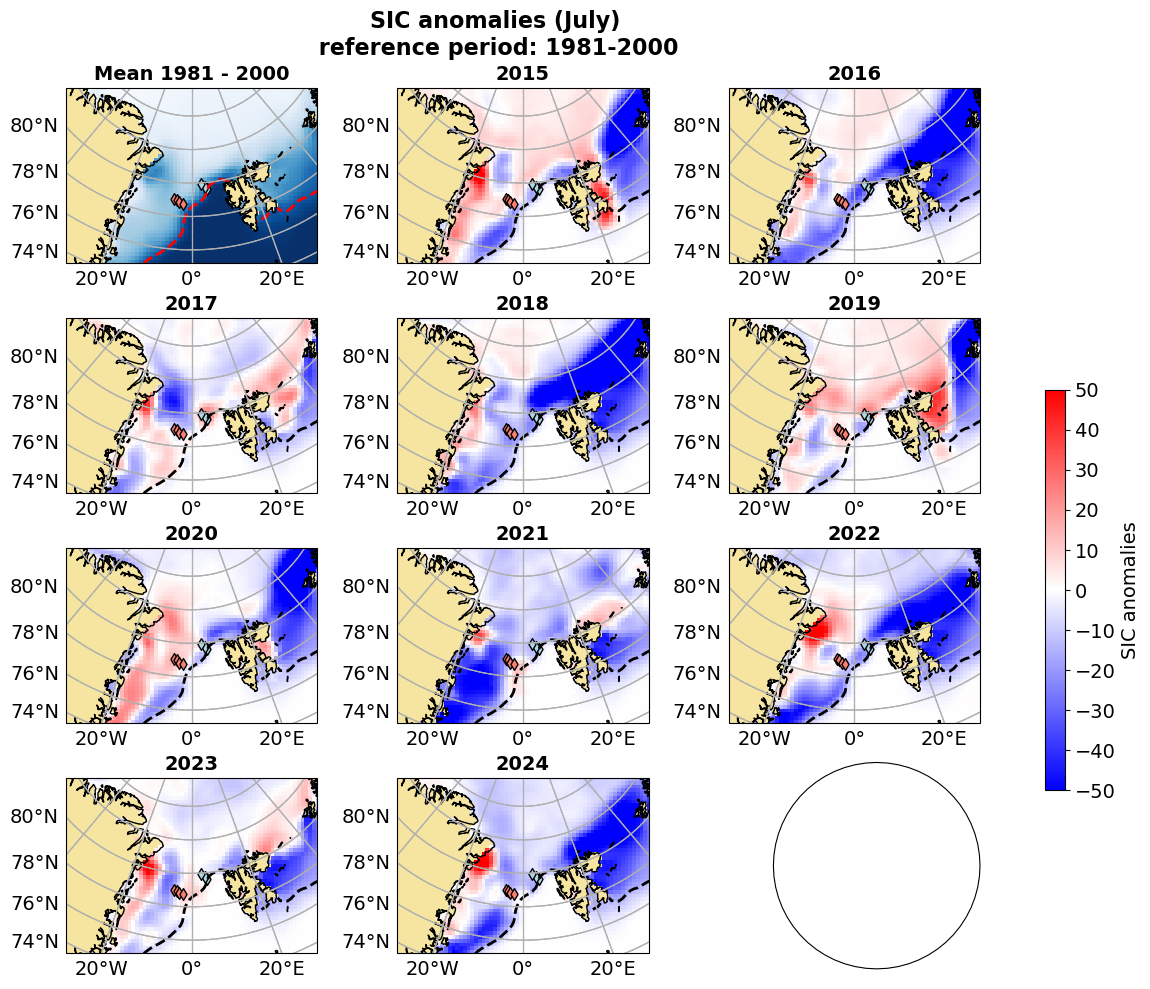

In [37]:
### NEW PLOT ###

fig, axs = plt.subplots(nrows=4,ncols=3,subplot_kw={'projection': ccrs.LambertAzimuthalEqualArea(central_longitude=0, central_latitude=90)},figsize=(10,10))
fig.subplots_adjust(wspace=0.2, hspace=0.2)
fig.suptitle(f"SIC anomalies ({calendar.month_name[month]})\n reference period: {refperiod[0]}-{refperiod[1]}",fontsize = 16, y = .98,fontweight = "bold")
for i,ax in enumerate(axs.flat[:10]):
    #print(ax)
    #continue
    if i>=sic_anom_new.shape[0]:
        continue
    if i == 0:
        design_map(ax,title = f"Mean {refperiod[0]} - {refperiod[1]}", hemisphere="nh",showlabels = True)
        im = ax.pcolormesh(x_2d*1e3,y_2d*1e3,ds_ref.sea_ice_concentration.mean(dim = "time"),cmap = plt.cm.Blues_r)
        add_contour(ax,ds_ref.sea_ice_concentration.mean(dim = "time"))
    else:
        design_map(ax,title = f"{sic_anom_new.time.dt.year[i-1].values}", hemisphere="nh",showlabels = True)
        im = ax.pcolormesh(x_2d*1e3,y_2d*1e3,sic_anom_new.isel(time=i-1),cmap = plt.cm.bwr,vmin = -50,vmax = 50)
        add_contour(ax,ds_ref.sea_ice_concentration.mean(dim = "time"),col = "black")
    for station_id in station_ids:
        if station_id.startswith("EG"):
            station_color = "salmon"
        else:
            station_color = "lightblue"
        ax.scatter(londict[station_id],latdict[station_id], transform = ccrs.PlateCarree(),marker = "d",facecolor = station_color, edgecolor = "black")
        
ax = axs.flat[10]
design_map(ax,title = f"{sic_anom_new.time.dt.year[-1].values}", hemisphere="nh",showlabels = True)
im = ax.pcolormesh(x_2d*1e3,y_2d*1e3,sic_anom_new.isel(time=-1),cmap = plt.cm.bwr,vmin = -50,vmax = 50)
add_contour(ax,ds_ref.sea_ice_concentration.mean(dim = "time"),col = "black")
for station_id in station_ids:
    if station_id.startswith("EG"):
        station_color = "salmon"
    else:
        station_color = "lightblue"
    ax.scatter(londict[station_id],latdict[station_id], transform = ccrs.PlateCarree(),marker = "d",facecolor = station_color, edgecolor = "black")

cb = fig.colorbar(im,ax = axs,shrink = .4)
cb.set_label("SIC anomalies",fontsize = 14)
cb.ax.set_yticks(range(-50,60,10))
cb.ax.tick_params(labelsize = 14)
cb.ax.set_position([1.05, 0.15, 0.02, 0.5])# [left, bottom, width, height]
plt.tight_layout()
fig.savefig(os.path.join(plotdir,f"sic_anom_{newperiod[0]}-{newperiod[1]}_{today}.png"),dpi = 300,bbox_inches = "tight")
fig.savefig(os.path.join(plotdir_paper,f"sic_anom_{newperiod[0]}-{newperiod[1]}.png"),dpi = 300,bbox_inches = "tight")
fig.show()
#plt.close(fig)
#sys.exit()

### Below: Map with stations

In [29]:
x_eg = [-24.5e4,-10e4, -20.5e4, -4.5e4][::-1] + [3.5e4,12.5e4,21.5e4][::-1]
y_eg = [-13.5e5,-13.5e5,-11e5,-11e5] + [-10e5,-10e5,-10e5]
va = ["top","top","bottom","bottom","bottom","bottom","bottom"]

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_8131/2599273680.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels([f"{t:0.0f}" for t in cbar.get_ticks()],fontsize = 14)
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_8131/2599273680.py:24: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


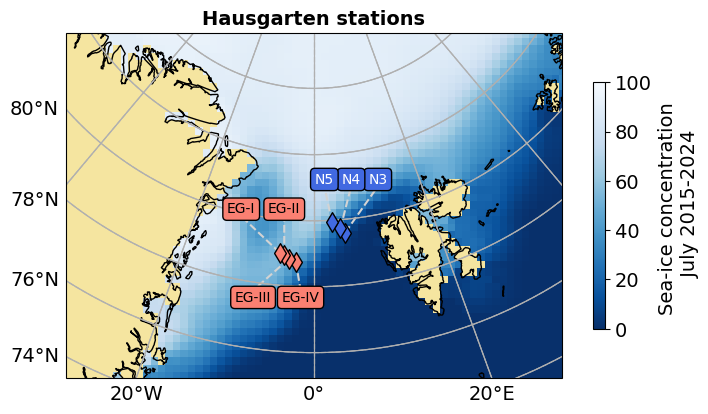

In [42]:

fig, ax = plt.subplots(nrows=1,ncols=1,subplot_kw={'projection': ccrs.LambertAzimuthalEqualArea(central_longitude=0, central_latitude=90)},figsize=(8,8))

design_map(ax,title = f"Hausgarten stations", hemisphere="nh",showlabels = True)
for i,station_id in enumerate([16,17,18,19,21,22,23]):
    if hausgarten_ice['Station ID'][station_id].startswith("EG"):
        ax.text(x_eg[i],y_eg[i], hausgarten_ice['Station ID'][station_id], color = "black",va = va[i],ha = "center",bbox=dict(facecolor=col2cluster("EG"), edgecolor='black', boxstyle='round,pad=0.3'),fontsize = 10)
        x_station,y_station = LatLon_To_XY(hausgarten_ice['lon_decimal'][station_id], hausgarten_ice['lat_decimal'][station_id],projstring=projstring)
        ax.plot([x_station,x_eg[i]],[y_station,y_eg[i]],color = "lightgrey", linestyle = "dashed")
        ax.scatter(hausgarten_ice['lon_decimal'][station_id], hausgarten_ice['lat_decimal'][station_id], transform = ccrs.PlateCarree(),color = col2cluster("EG"),marker = "d",s = 100,edgecolor = "k",zorder = 99)
    else:
        ax.text(x_eg[i],y_eg[i], hausgarten_ice['Station ID'][station_id], color = "white",va = va[i],ha = "center",bbox=dict(facecolor=col2cluster("N"), edgecolor='black', boxstyle='round,pad=0.3'),fontsize = 10)
        x_station,y_station = LatLon_To_XY(hausgarten_ice['lon_decimal'][station_id], hausgarten_ice['lat_decimal'][station_id],projstring=projstring)
        ax.plot([x_station,x_eg[i]],[y_station,y_eg[i]],color = "lightgrey", linestyle = "dashed")
        ax.scatter(hausgarten_ice['lon_decimal'][station_id], hausgarten_ice['lat_decimal'][station_id], transform = ccrs.PlateCarree(),color = col2cluster("N"),marker = "d",s = 100,edgecolor = "k",zorder = 99)
# Add legend (one entry per unique label)
#ax.legend(ncol = 3)
cax = ax.pcolormesh(x_2d*1e3,y_2d*1e3,ds_new.sea_ice_concentration.mean(dim="time"),cmap = plt.cm.Blues_r,vmin = 0, vmax = 100)
cbar = fig.colorbar(cax,ax = ax,shrink = .4,label = f"Sea-ice concentration \n {calendar.month_name[month]} {ds_new.time.dt.year.min().values}-{ds_new.time.dt.year.max().values}")
#cbar.ax.tick_params(labelsize=14)
cbar.set_ticklabels([f"{t:0.0f}" for t in cbar.get_ticks()],fontsize = 14)
cbar.set_label(f"Sea-ice concentration \n {calendar.month_name[month]} {ds_new.time.dt.year.min().values}-{ds_new.time.dt.year.max().values}",fontsize = 14)
fig.savefig(os.path.join(plotdir,f"stations_{today}.png"),dpi = 300,bbox_inches = "tight")

fig.show()
#plt.close(fig)
#sys.exit()

#### Below with no-ice stations

/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_8131/3978870626.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cbar.set_ticklabels([f"{t:0.0f}" for t in cbar.get_ticks()],fontsize = 14)
/var/folders/d6/cf68qnyn42708tqdllr3pbmjmsjrs2/T/ipykernel_8131/3978870626.py:26: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


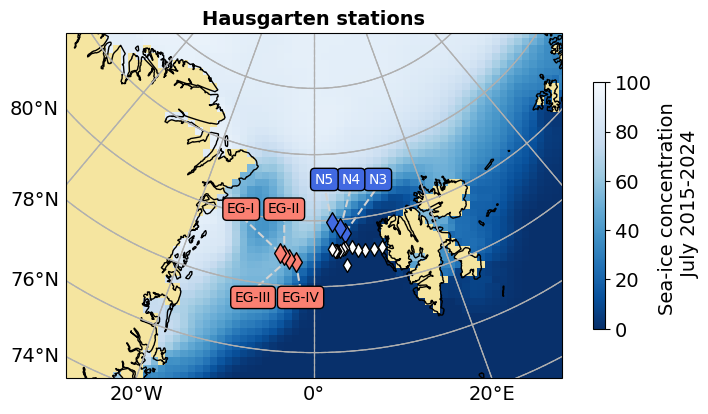

In [46]:

fig, ax = plt.subplots(nrows=1,ncols=1,subplot_kw={'projection': ccrs.LambertAzimuthalEqualArea(central_longitude=0, central_latitude=90)},figsize=(8,8))

design_map(ax,title = f"Hausgarten stations", hemisphere="nh",showlabels = True)
for i,station_id in enumerate([16,17,18,19,21,22,23]):
    if hausgarten_ice['Station ID'][station_id].startswith("EG"):
        ax.text(x_eg[i],y_eg[i], hausgarten_ice['Station ID'][station_id], color = "black",va = va[i],ha = "center",bbox=dict(facecolor=col2cluster("EG"), edgecolor='black', boxstyle='round,pad=0.3'),fontsize = 10)
        x_station,y_station = LatLon_To_XY(hausgarten_ice['lon_decimal'][station_id], hausgarten_ice['lat_decimal'][station_id],projstring=projstring)
        ax.plot([x_station,x_eg[i]],[y_station,y_eg[i]],color = "lightgrey", linestyle = "dashed")
        ax.scatter(hausgarten_ice['lon_decimal'][station_id], hausgarten_ice['lat_decimal'][station_id], transform = ccrs.PlateCarree(),color = col2cluster("EG"),marker = "d",s = 100,edgecolor = "k",zorder = 99)
    else:
        ax.text(x_eg[i],y_eg[i], hausgarten_ice['Station ID'][station_id], color = "white",va = va[i],ha = "center",bbox=dict(facecolor=col2cluster("N"), edgecolor='black', boxstyle='round,pad=0.3'),fontsize = 10)
        x_station,y_station = LatLon_To_XY(hausgarten_ice['lon_decimal'][station_id], hausgarten_ice['lat_decimal'][station_id],projstring=projstring)
        ax.plot([x_station,x_eg[i]],[y_station,y_eg[i]],color = "lightgrey", linestyle = "dashed")
        ax.scatter(hausgarten_ice['lon_decimal'][station_id], hausgarten_ice['lat_decimal'][station_id], transform = ccrs.PlateCarree(),color = col2cluster("N"),marker = "d",s = 100,edgecolor = "k",zorder = 99)
# Add legend (one entry per unique label)
#ax.legend(ncol = 3)
ax.scatter(hausgarten_noice['lon_decimal'], hausgarten_noice['lat_decimal'], transform = ccrs.PlateCarree(),color = "white",marker = "d",s = 50,edgecolor = "k",zorder = 99)
cax = ax.pcolormesh(x_2d*1e3,y_2d*1e3,ds_new.sea_ice_concentration.mean(dim="time"),cmap = plt.cm.Blues_r,vmin = 0, vmax = 100)
cbar = fig.colorbar(cax,ax = ax,shrink = .4,label = f"Sea-ice concentration \n {calendar.month_name[month]} {ds_new.time.dt.year.min().values}-{ds_new.time.dt.year.max().values}")
#cbar.ax.tick_params(labelsize=14)
cbar.set_ticklabels([f"{t:0.0f}" for t in cbar.get_ticks()],fontsize = 14)
cbar.set_label(f"Sea-ice concentration \n {calendar.month_name[month]} {ds_new.time.dt.year.min().values}-{ds_new.time.dt.year.max().values}",fontsize = 14)
fig.savefig(os.path.join(plotdir,f"stations_ALL_{today}.png"),dpi = 300,bbox_inches = "tight")
fig.savefig(os.path.join(plotdir_paper,f"stations_ALL.png"),dpi = 300,bbox_inches = "tight")

fig.show()
#plt.close(fig)
#sys.exit()